In [22]:
import numpy as np
import pandas as pd
import datetime
import os
import time
import matplotlib.pyplot as plt
import seaborn as sns
import gc
%matplotlib inline

In [23]:
# 그래프 크기 조정
sns.set(rc={'figure.figsize':(12,5)})
plt.figure(figsize=(12,5))

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

# 데이터셋 설명

- ip: 클릭한 사용자의 IP 주소
- app: 광고를 통해 마케팅된 앱의 ID
- device: 사용자 모바일 기기의 디바이스 타입 ID (예: iPhone 6 Plus, iPhone 7, Huawei Mate 7 등)
- os: 사용자 모바일 기기의 운영체제(Operating System) 버전 ID
- channel: 모바일 광고 게시자의 채널(Channel) ID
- click_time: 클릭 타임스탬프 (UTC)
- attributed_time: 사용자가 광고를 클릭한 후 앱을 다운로드한 경우, 앱 다운로드 시간
- is_attributed: 예측해야 할 대상(Target)으로, 앱이 다운로드된 경우 1을, 그렇지 않은 경우 0을 나타냅니다.

ip, app, device, os 및 channel은 인코딩되어 있습니다.

테스트 데이터는 유사하지만, 다음과 같은 차이점이 있습니다.

- click_id: 예측을 위한 참조(reference)
- is_attributed: 포함되어 있지 않습니다.

(추가)
- network id : 네트워크를 식별하는 데 사용되는 식별자. 전체 네트워크에서 고유한 ID를 의미함

# 대용량 데이터 다루기

## 데이터 설명

'is_attributed == 1'은 click이 전환되었음을 의미함

### 사용하지않는 변수 삭제하기

pandas에서 dataframe 복사 후 원본을 다신 사용하지않으면 memory leak이 생김. RAM에 원본 dataframe이 여전히 남아있기 때문임. <br>
따라서, dataframe을 다 사용했다면 삭제하는 습관을 가지는 것이 좋은데 이때 유용한 것이 garbage collection module임.<br>
변수를 복사/참조한 후 gc.collect() 명령을 실행한다면, 메모리 관리에 도움이 될 것임.

In [24]:
temp = pd.read_csv('/kaggle/input/talkingdata-adtracking-fraud-detection/train_sample.csv')
temp['os'] = temp['os'].astype('str')

In [25]:
# 더 이상 사용하지않기에 지우기
del temp
# gc
gc.collect()

3289

### data type 미리 세팅하기
메모리를 위해 데이터가 특정 값 이상으로 커지지 않는다는 것을 미리 알고있을 땐, data type을 minimum requirements로 세팅할 것

In [26]:
dtypes = {
        'ip'            : 'uint32',
        'app'           : 'uint16',
        'device'        : 'uint16',
        'os'            : 'uint16',
        'channel'       : 'uint16',
        'is_attributed' : 'uint8',
}

train = pd.read_csv('/kaggle/input/talkingdata-adtracking-fraud-detection/train_sample.csv', dtype = dtypes)

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   ip               100000 non-null  uint32
 1   app              100000 non-null  uint16
 2   device           100000 non-null  uint16
 3   os               100000 non-null  uint16
 4   channel          100000 non-null  uint16
 5   click_time       100000 non-null  object
 6   attributed_time  227 non-null     object
 7   is_attributed    100000 non-null  uint8 
dtypes: object(2), uint16(4), uint32(1), uint8(1)
memory usage: 2.8+ MB


### csv 선택된 행만 가져오기

1) import할 row 선택

pd.read_csv('../input/train.csv', nrows=10000)로 처음 10000개 행만 읽어오기

In [27]:
train = pd.read_csv('/kaggle/input/talkingdata-adtracking-fraud-detection/train.csv', nrows = 10_000, dtype = dtypes)
train.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,83230,3,1,13,379,2017-11-06 14:32:21,NaN,0
1,17357,3,1,19,379,2017-11-06 14:33:34,NaN,0
2,35810,3,1,13,379,2017-11-06 14:34:12,NaN,0
3,45745,14,1,13,478,2017-11-06 14:34:52,NaN,0
4,161007,3,1,13,379,2017-11-06 14:35:08,NaN,0


2) row skip하기

train = pd.read_csv('../input/train.csv', skiprows=5000000, nrows=1000000)의 방법으로 skip할 행의 수를 명시해주기

그러나 이 방법은 column명이 무시되기에 column명이 없거나, custom을 할 경우에 많이 사용함

In [28]:
_train = pd.read_csv('/kaggle/input/talkingdata-adtracking-fraud-detection/train.csv',
                    skiprows = 5_000_000, nrows = 1_000_000, header = None, dtype=dtypes)
train.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,83230,3,1,13,379,2017-11-06 14:32:21,NaN,0
1,17357,3,1,19,379,2017-11-06 14:33:34,NaN,0
2,35810,3,1,13,379,2017-11-06 14:34:12,NaN,0
3,45745,14,1,13,478,2017-11-06 14:34:52,NaN,0
4,161007,3,1,13,379,2017-11-06 14:35:08,NaN,0


In [29]:
# 첫번째 행을 쓰고 싶을 때

train = pd.read_csv('/kaggle/input/talkingdata-adtracking-fraud-detection/train.csv',
                   skiprows = range(1, 5_000_000), nrows = 1_000_000, dtype = dtypes)
train.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,37363,12,1,25,245,2017-11-06 20:27:57,NaN,0
1,89913,2,1,9,469,2017-11-06 20:27:57,NaN,0
2,114235,26,1,13,121,2017-11-06 20:27:57,NaN,0
3,18839,3,1,19,442,2017-11-06 20:27:57,NaN,0
4,105580,15,1,13,245,2017-11-06 20:27:57,NaN,0


3) 원하지 않는 row list만들어서 skip할 row 선택하기

무작위로 sampling하는 방으로, 원하는 방식으로 data sampling 가능

In [30]:
import subprocess

def file_len(fname):
    p = subprocess.Popen(['wc', '-l', fname], stdout=subprocess.PIPE, 
                                              stderr=subprocess.PIPE)
    result, err = p.communicate()
    if p.returncode != 0:
        raise IOError(err)
    return int(result.strip().split()[0])

lines = file_len('/kaggle/input/talkingdata-adtracking-fraud-detection/train.csv')
print('Number of lines in "train.csv" is : ', lines)

Number of lines in "train.csv" is :  184903891


무작위로 row 생략 후 1 ~ 1000000 index를 가진 데이터로 추출하기.

메모리 공간을 많이 차지하고 시간이 오래걸리기 때문에 del과 gc.collect() 사용해야함

In [31]:
# skip할 row 뽑아내기
skiplines = np.random.choice(np.arange(1, lines), 
                             size=lines-1-1_000_000, replace=False)

# sort
skiplines = np.sort(skiplines)

In [32]:
#list 확인해보기
print('lines to skip', len(skiplines))
print('remaining lines in sample : ', lines-len(skiplines),
     '(rememeber that it includes the heading!)')

lines to skip 183903890
remaining lines in sample :  1000001 (rememeber that it includes the heading!)


In [33]:
# 건너뛰지 않은 row 확인하기
# 처음 100,000개 중 skiplines에 포함된 비율 확인하기.
diff = skiplines[1:100_000] - skiplines[2:100_001]
remain = sum(diff != -1)
print('Ratio of lines from first 100_000 lines:', '{0:.5f}'.format(remain/100_000))
print('Ratio imported from all lines : ', '{0:.5f}'.format((lines - len(skiplines)) / lines) )

Ratio of lines from first 100_000 lines: 0.00508
Ratio imported from all lines :  0.00541


코드 이해를 위한 설명!!

1. 샘플링된 라인 중 첫 100000개의 라인이 샘플링되었는지 확인하기 위한 "sanity check"를 수행

2. 이를 위해, skiplines 변수에서 첫 100000개의 값을 선택 후, 연속된 값들의 차이를 계산 진행. 

3. -1이 아닌 값의 수를 세어 이를 remain 변수에 할당

4. 모든 라인 중에서 샘플링된 라인의 비율과 첫 100000개의 라인 중에서 샘플링된 라인의 비율을 출력

In [34]:
# random으로 선택된 row 가져오기

train = pd.read_csv('/kaggle/input/talkingdata-adtracking-fraud-detection/train.csv', 
                    skiprows=skiplines, dtype=dtypes)
train.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,44615,3,1,19,379,2017-11-06 15:56:17,NaN,0
1,75825,12,1,1,328,2017-11-06 16:00:00,NaN,0
2,171396,15,1,9,245,2017-11-06 16:00:01,NaN,0
3,49515,8,1,10,145,2017-11-06 16:00:01,NaN,0
4,208669,13,1,19,477,2017-11-06 16:00:01,NaN,0


In [35]:
del skiplines
gc.collect()

138

time stamp를 time series로 변경

1. time stamp
- 한 시점을 나타내는 데이터
- 2023년 04월 13일 오후 4시 23분의 화면 클릭 수 등

2. time series
- 시간에 흐름에 따른 변화량(연속된 시퀀스)을 나타내는 데이터
- 2022년 1월부터 12월까지 시간의 변화에 따른 판매량 등

In [36]:
train['click_time'] = pd.to_datetime(train['click_time'])
train['attributed_time'] = pd.to_datetime(train['attributed_time'])

In [37]:
train.describe(include = 'all')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.


,ip,app,device,os,channel,click_time,attributed_time,is_attributed
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000,2528,1000000.000000
unique,NaN,NaN,NaN,NaN,NaN,234195,2520,NaN
top,NaN,NaN,NaN,NaN,NaN,2017-11-08 02:48:06,2017-11-09 03:10:18,NaN
freq,NaN,NaN,NaN,NaN,NaN,19,2,NaN
first,NaN,NaN,NaN,NaN,NaN,2017-11-06 15:56:17,2017-11-06 16:05:24,NaN
last,NaN,NaN,NaN,NaN,NaN,2017-11-09 16:00:00,2017-11-09 15:59:06,NaN
mean,90913.724716,12.040449,22.201516,22.755498,268.635333,NaN,NaN,0.002528
std,69602.437759,14.854408,262.501373,55.690248,129.568816,NaN,NaN,0.050216
min,1.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,0.000000
25%,40216.000000,3.000000,1.000000,13.000000,140.000000,NaN,NaN,0.000000


dataframe이 클릭 시간 별로 정리되어있음.
따라서 ramdomly sampling한 데이터도 원본 데이터와 같은 기간을 가져야 함.

원본 dataframe은 4일에 걸쳐 데이터를 측정함

Text(0, 0.5, 'Converted Ratio')

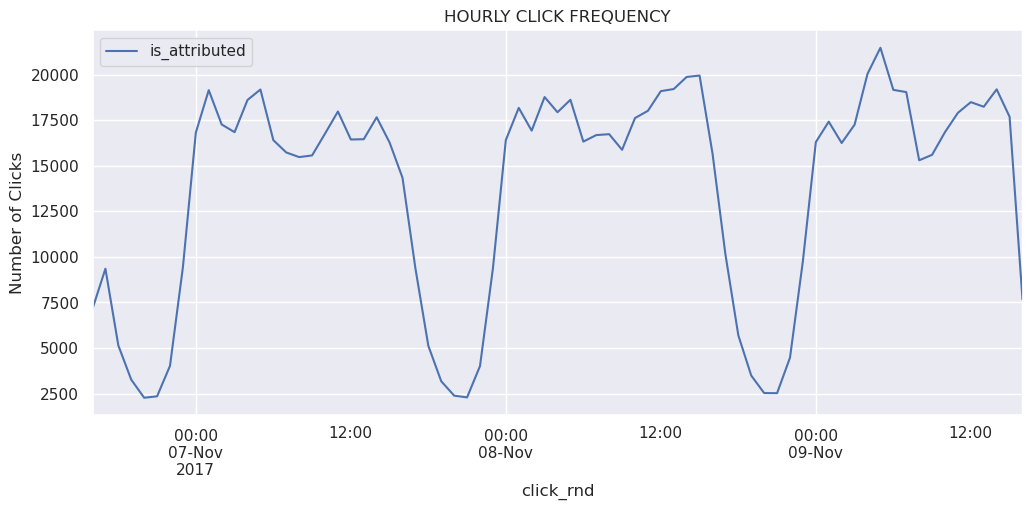

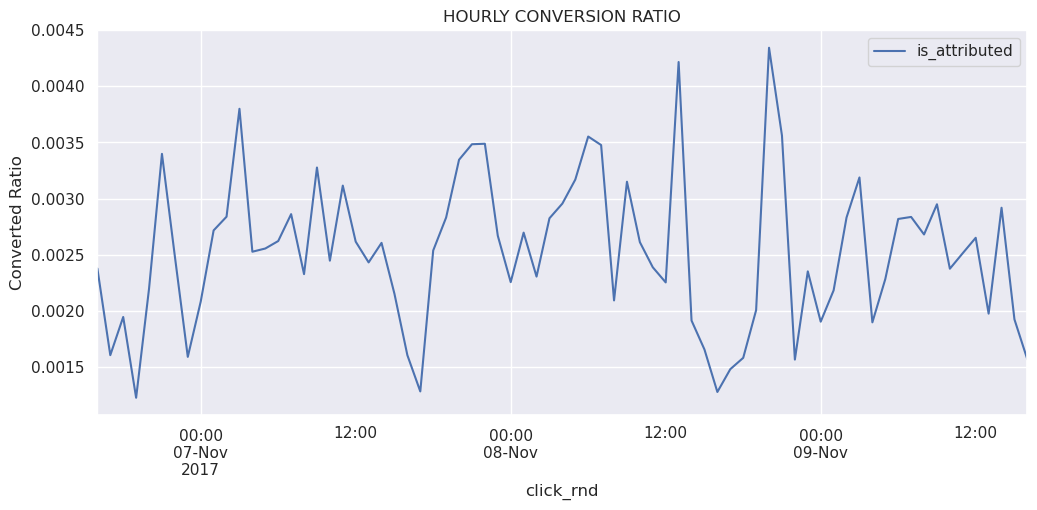

In [38]:
# 가장 가까운 시간대로 나타냄
train['click_rnd'] = train['click_time'].dt.round('H')  

# 시간별 패턴 확인하기
train[['click_rnd','is_attributed']].groupby(['click_rnd'], as_index = True).count().plot()
plt.title('HOURLY CLICK FREQUENCY')
plt.ylabel('Number of Clicks')

train[['click_rnd','is_attributed']].groupby(['click_rnd'], as_index = True).mean().plot()
plt.title('HOURLY CONVERSION RATIO')
plt.ylabel('Converted Ratio')

### chunk 별로 데이터를 불러오고 각 dataframe 전처리 진행

클릭 후 다운로드를 한 비율을 알고 싶다고 가정했을 때, 전체 데이터를 로드하고 필터링을 하기엔 메모리를 너무 많이 잡아먹고, 시간이 오래 걸림.
따라서 chunk 단위로 필요한 정보만 추출하고, 나머지는 제거할 수 있음.

방법 : chunk 단위를 정한 후, 각 크기만큼 import 함. 다운로드 비율을 알고싶기에 s_attributed' == 1인 데이터만 가져올 것임

In [39]:
# empty dataframe
df_converted = pd.DataFrame()

chunksize = 10 ** 6

for chunk in pd.read_csv('/kaggle/input/talkingdata-adtracking-fraud-detection/train.csv', 
                         chunksize=chunksize, dtype = dtypes):
    filtered = (chunk[(np.where(chunk['is_attributed'] == 1, True, False))])
    df_converted = pd.concat([df_converted, filtered], ignore_index = True, )

In [40]:
df_converted.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 456846 entries, 0 to 456845
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   ip               456846 non-null  uint32
 1   app              456846 non-null  uint16
 2   device           456846 non-null  uint16
 3   os               456846 non-null  uint16
 4   channel          456846 non-null  uint16
 5   click_time       456846 non-null  object
 6   attributed_time  456846 non-null  object
 7   is_attributed    456846 non-null  uint8 
dtypes: object(2), uint16(4), uint32(1), uint8(1)
memory usage: 12.6+ MB


### 선택된 컬럼만 가져오기

In [41]:
columns = ['ip', 'click_time', 'is_attributed']
dtypes = {
        'ip'            : 'uint32',
        'is_attributed' : 'uint8',
        }

ips_df = pd.read_csv('/kaggle/input/talkingdata-adtracking-fraud-detection/train.csv', usecols=columns, dtype=dtypes)

In [42]:
print(ips_df.info())
print(ips_df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 184903890 entries, 0 to 184903889
Data columns (total 3 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   ip             uint32
 1   click_time     object
 2   is_attributed  uint8 
dtypes: object(1), uint32(1), uint8(1)
memory usage: 2.2+ GB
None
       ip           click_time  is_attributed
0   83230  2017-11-06 14:32:21              0
1   17357  2017-11-06 14:33:34              0
2   35810  2017-11-06 14:34:12              0
3   45745  2017-11-06 14:34:52              0
4  161007  2017-11-06 14:35:08              0


### section별로 preprocessing

In [43]:
ips_df[0:100][['ip', 'is_attributed']].groupby('ip', as_index=False).count()[:10]

,ip,is_attributed
0,1025,1
1,2805,1
2,3425,1
3,3653,1
4,6242,1
5,7755,1
6,16760,1
7,17357,1
8,18787,1
9,23550,1


section 별로 계산 후 total count하는 방법으로 ip별 click 횟수 계산

In [44]:
size = 100_000
all_rows = len(ips_df)
num_parts = all_rows//size

# 첫 batch 만들기
# 나중에 dataframe을 merge할 것이기 때문에 따로 만들어두기
ip_counts = ips_df[0:size][['ip', 'is_attributed']].groupby('ip', as_index=False).count()

## 남은 batches 더하기
for p in range(1,num_parts):
    start = p*size
    end = p*size + size
    if end < all_rows:
        group = ips_df[start:end][['ip', 'is_attributed']].groupby('ip', as_index=False).count()
    else:
        # 마지막 chunk는 dataframe 끝까지 포함시키기 때문
        group = ips_df[start:][['ip', 'is_attributed']].groupby('ip', as_index=False).count()
    ip_counts = ip_counts.merge(group, on='ip', how='outer')
    ip_counts.columns = ['ip', 'count1','count2']
    ip_counts['counts'] = np.nansum((ip_counts['count1'], ip_counts['count2']), axis = 0)
    ip_counts.drop(columns=['count1', 'count2'], axis = 0, inplace=True)

In [45]:
ip_counts.head()

,ip,counts
0,31,1039.0
1,36,6743.0
2,60,670.0
3,81,519.0
4,92,4457.0


In [46]:
# count 많은 순으로 정렬
ip_counts.sort_values('counts', ascending=False)[:20]

,ip,counts
490,5348,1238701.0
483,5314,1171427.0
6336,73516,770418.0
6331,73487,763823.0
4619,53454,498171.0
9852,114276,427449.0
2282,26995,401484.0
8200,95766,378684.0
1486,17149,310985.0
9041,105475,302180.0


In [47]:
# 전체 count sum
np.sum(ip_counts['counts'])

184900000.0

IP별 전환 비율을 원한다고 가정하고, 전환의 합계를 구한 다음 카운트로 나누기

In [48]:
size = 100_000
all_rows = len(ips_df)
num_parts = all_rows//size

# 처음 batch
ip_sums = ips_df[0:size][['ip', 'is_attributed']].groupby('ip',as_index = False).sum()

# 나머지 batch
for p in range(1,num_parts):
    start = p*size
    end = p*size + size
    if end < all_rows:
        group = ips_df[start:end][['ip', 'is_attributed']].groupby('ip', as_index=False).sum()
    else:
        group = ips_df[start:][['ip', 'is_attributed']].groupby('ip', as_index=False).sum()
    ip_sums = ip_sums.merge(group, on='ip', how='outer')
    ip_sums.columns = ['ip', 'sum1','sum2']
    ip_sums['conversions_per_ip'] = np.nansum((ip_sums['sum1'], ip_sums['sum2']), axis = 0)
    ip_sums.drop(columns=['sum1', 'sum2'], axis = 0, inplace=True)

In [49]:
ip_sums.head(10)

,ip,conversions_per_ip
0,31,3.0
1,36,6.0
2,60,2.0
3,81,0.0
4,92,3.0
5,95,2.0
6,122,4.0
7,126,7.0
8,151,5.0
9,169,1.0


In [50]:
# 비울 계산
np.sum(ip_sums['conversions_per_ip']) / 184900000

0.002470773391022174

In [51]:
# click에서 ip로의 전환 비울 계산하기
ip_conversions = ip_counts.merge(ip_sums, on='ip', how='left')
ip_conversions.head()

,ip,counts,conversions_per_ip
0,31,1039.0,3.0
1,36,6743.0,6.0
2,60,670.0,2.0
3,81,519.0,0.0
4,92,4457.0,3.0


In [52]:
ip_conversions['converted_ratio'] = ip_conversions['conversions_per_ip'] / ip_conversions['counts']
ip_conversions[:10]

,ip,counts,conversions_per_ip,converted_ratio
0,31,1039.0,3.0,0.002887
1,36,6743.0,6.0,0.000890
2,60,670.0,2.0,0.002985
3,81,519.0,0.0,0.000000
4,92,4457.0,3.0,0.000673
5,95,2676.0,2.0,0.000747
6,122,4213.0,4.0,0.000949
7,126,3017.0,7.0,0.002320
8,151,2956.0,5.0,0.001691
9,169,1619.0,1.0,0.000618


In [53]:
# cleanup
del ip_conversions
del ip_sums
del ips_df
del df_converted
del train
gc.collect()

3352

### Dask 이용

#### Dask?

- 대규모 cluster에 적용가능한 parallel computing(병렬 컴퓨팅)용 python 라이브러리

#### 어떤 역할?

- numpy,pandas 병렬 처리
- 기존 메모리보다 더 큰 데이터로 작업 가능하도록 만듦
- RAM에 맞게 계산 처리

In [54]:
# dask 라이브러리 import
import dask
import dask.dataframe as dd

In [55]:
# train 타입 데이터 loading
dtypes = {'ip':'uint32',
          'app': 'uint16',
          'device': 'uint16',
          'os': 'uint16',
          'channel': 'uint16',
          'is_attributed': 'uint8'}

train = dd.read_csv('/kaggle/input/talkingdata-adtracking-fraud-detection/train.csv',
                   dtype=dtypes, parse_dates=['click_time', 'attributed_time'])
train.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,83230,3,1,13,379,2017-11-06 14:32:21,NaT,0
1,17357,3,1,19,379,2017-11-06 14:33:34,NaT,0
2,35810,3,1,13,379,2017-11-06 14:34:12,NaT,0
3,45745,14,1,13,478,2017-11-06 14:34:52,NaT,0
4,161007,3,1,13,379,2017-11-06 14:35:08,NaT,0


잘 불러와졌는지 확인하기

In [56]:
train.info()

<class 'dask.dataframe.core.DataFrame'>
Columns: 8 entries, ip to is_attributed
dtypes: datetime64[ns](2), uint16(4), uint32(1), uint8(1)

In [57]:
len(train)

184903890

In [58]:
train.columns

Index(['ip', 'app', 'device', 'os', 'channel', 'click_time', 'attributed_time',
       'is_attributed'],
      dtype='object')

subset 구성 확인하기

In [59]:
train[train['is_attributed']==1].head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
103,204158,35,1,13,21,2017-11-06 15:41:07,2017-11-07 08:17:19,1
1504,29692,9,1,22,215,2017-11-06 16:00:02,2017-11-07 10:05:22,1
1798,64516,35,1,13,21,2017-11-06 16:00:02,2017-11-06 23:40:50,1
2102,172429,35,1,46,274,2017-11-06 16:00:03,2017-11-07 00:55:29,1
3056,199085,35,1,13,274,2017-11-06 16:00:04,2017-11-06 23:04:54,1


In [60]:
train[train['attributed_time']>='2017-11-07 00:00:00'].head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
103,204158,35,1,13,21,2017-11-06 15:41:07,2017-11-07 08:17:19,1
1504,29692,9,1,22,215,2017-11-06 16:00:02,2017-11-07 10:05:22,1
2102,172429,35,1,46,274,2017-11-06 16:00:03,2017-11-07 00:55:29,1
3220,82917,19,0,24,210,2017-11-06 16:00:04,2017-11-07 00:21:50,1
5438,24200,19,88,24,213,2017-11-06 16:00:07,2017-11-07 04:18:51,1


조금 더 무거운 연산 해보기 : ip count

-> dask는 메모리보다 큰 연산에 유리하기에 진행해보기

In [61]:
ip_counts = train.ip.value_counts().compute()
ip_counts[:20]

5348      1238734
5314      1171448
73516      770451
73487      763854
53454      498186
114276     427453
26995      401495
95766      378693
17149      310996
105475     302192
100275     276799
43793      261970
105560     260049
86767      257649
111025     247187
137052     217614
201182     212448
5178       211556
49602      200053
5147       197994
Name: ip, dtype: int64

In [62]:
# 메모리를 위해 필요없는 객체 삭제해주기

del ip_counts
gc.collect()

53

In [63]:
# conversion 평균값 구하기
channel_means = train[['channel', 'is_attributed']].groupby('channel').mean().compute()
channel_means[:20]

,is_attributed
channel,
0,0.077345
3,0.000413
13,0.000121
15,0.000173
17,0.000188
18,0.000525
19,0.000224
21,0.140053
22,0.001292


In [64]:
# index 따로 설정해주기
channel_means = channel_means.reset_index()
channel_means[:20]

,channel,is_attributed
0,0,0.077345
1,3,0.000413
2,13,0.000121
3,15,0.000173
4,17,0.000188
5,18,0.000525
6,19,0.000224
7,21,0.140053
8,22,0.001292
9,24,0.000170


In [65]:
# 메모리를 위해 필요없는 객체 삭제해주기

del channel_means
gc.collect()

46

## License

This Notebook has been released under the Apache 2.0 open source license.

refer : kaggle[How to Work with BIG Datasets on 16G RAM (+Dask)](https://www.kaggle.com/code/yuliagm/how-to-work-with-big-datasets-on-16g-ram-dask)

# EDA

In [66]:
# 10,000,000열만 가져오기
train = pd.read_csv('/kaggle/input/talkingdata-adtracking-fraud-detection/train.csv', nrows=10000000)
test = pd.read_csv('/kaggle/input/talkingdata-adtracking-fraud-detection/test.csv')

In [67]:
train.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,83230,3,1,13,379,2017-11-06 14:32:21,NaN,0
1,17357,3,1,19,379,2017-11-06 14:33:34,NaN,0
2,35810,3,1,13,379,2017-11-06 14:34:12,NaN,0
3,45745,14,1,13,478,2017-11-06 14:34:52,NaN,0
4,161007,3,1,13,379,2017-11-06 14:35:08,NaN,0


ip, app, device, os, channel은 integer로 인코딩된 범주형 변수이므로 카테고리 별로 설정하기

In [70]:
variables = ['ip', 'app', 'device', 'os', 'channel']
for v in variables:
    train[v] = train[v].astype('category')
    test[v]=test[v].astype('category')

date stamp를 date/time 유형으로 변환

In [71]:
# click_time, attributed_time을 timeseries로 변환
train['click_time'] = pd.to_datetime(train['click_time'])
train['attributed_time'] = pd.to_datetime(train['attributed_time'])
test['click_time'] = pd.to_datetime(test['click_time'])

# is_attributed도 카테고리로 넣기
train['is_attributed'] = train['is_attributed'].astype('category')

In [72]:
train.describe()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.


,ip,app,device,os,channel,click_time,attributed_time,is_attributed
count,10000000.0,10000000.0,10000000.0,10000000.0,10000000.0,10000000,18717,10000000.0
unique,68740.0,332.0,940.0,292.0,170.0,29943,15698,2.0
top,73516.0,12.0,1.0,19.0,245.0,2017-11-06 16:05:10,2017-11-06 23:36:23,0.0
freq,51711.0,1291185.0,9381146.0,2410148.0,793105.0,1261,6,9981283.0
first,NaN,NaN,NaN,NaN,NaN,2017-11-06 14:32:21,2017-11-06 16:00:47,NaN
last,NaN,NaN,NaN,NaN,NaN,2017-11-07 00:12:03,2017-11-07 15:59:53,NaN


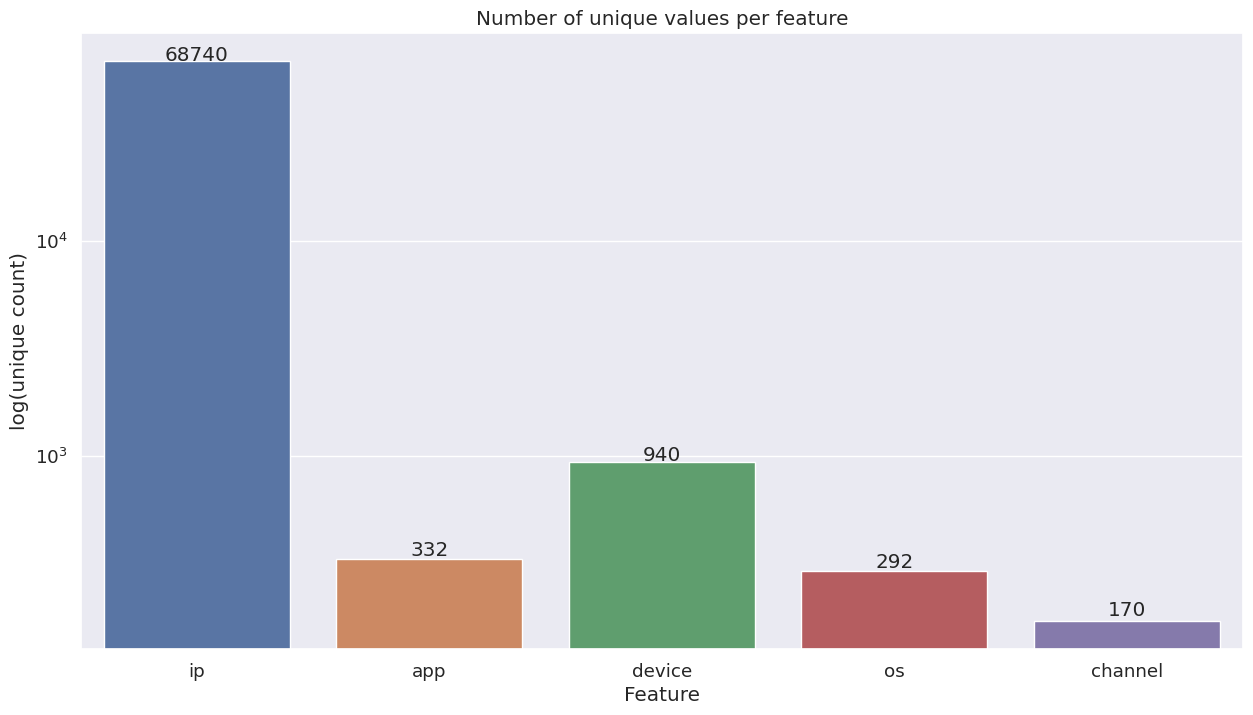

In [73]:
plt.figure(figsize=(15, 8))
cols = ['ip', 'app', 'device', 'os', 'channel']
uniques = [len(train[col].unique()) for col in cols]
sns.set(font_scale=1.2)
ax = sns.barplot(x=cols, y=uniques, log=True)
ax.set(xlabel='Feature', ylabel='log(unique count)', title='Number of unique values per feature')
for p, uniq in zip(ax.patches, uniques):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 10,
            uniq,
            ha="center")

In [74]:
# download된 값이 'is_attributed == 1'이 맞는지 더블체크
train[['attributed_time', 'is_attributed']][train['is_attributed']==1].describe()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  


,attributed_time,is_attributed
count,18717,18717.0
unique,15698,1.0
top,2017-11-06 23:36:23,1.0
freq,6,18717.0
first,2017-11-06 16:00:47,NaN
last,2017-11-07 15:59:53,NaN


In [75]:
test['click_id'] = test['click_id'].astype('category')
test.describe()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  


,click_id,ip,app,device,os,channel,click_time
count,18790469.0,18790469.0,18790469.0,18790469.0,18790469.0,18790469.0,18790469
unique,18790469.0,93936.0,417.0,1985.0,395.0,178.0,21603
top,0.0,5348.0,9.0,1.0,19.0,107.0,2017-11-10 09:00:10
freq,1.0,182522.0,2872176.0,17360269.0,4334532.0,1214650.0,1466
first,NaN,NaN,NaN,NaN,NaN,NaN,2017-11-10 04:00:00
last,NaN,NaN,NaN,NaN,NaN,NaN,2017-11-10 15:00:00


### Observation

- attributed_time 값은 총 18,717개로, 10,000,000개의 클릭 중 다운로드로 이어진 것은 0.2% 미만을 의미함
- 학습 데이터 세트에서 첫 번째 클릭은 2017년 11월 6일 14시 32분 21초에 발생하며, 테스트 클릭은 2017년 11월 10일에 시작 
- 학습은 4일 기간을 커버하며, 테스트 데이터는 학습 데이터가 끝난 다음 날에 수집
- 학습 데이터는 타임스탬프에 따라 정렬되며, 순서대로 추출된 배치는 제한된 시간 범위를 커버
- 학습은 월요일부터 목요일까지 진행되며, 테스트는 금요일에 시작
- 테스트 데이터에는 누락된 데이터가 없으며, 학습 데이터에서는 attributed_time 값만이 누락

(아래의 코드 참조)
- 한 ip가 50,000번 이상 클릭한 것으로 보아, Network ID일 가능성도 있음.

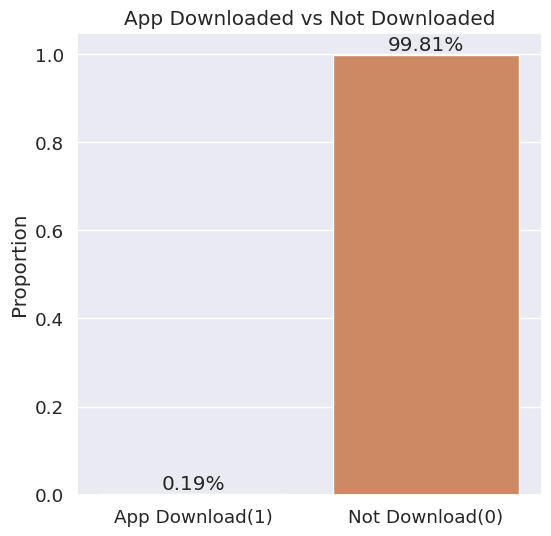

In [76]:
# 다운로드까지 이어진 클릭 수의 비율 구하기

plt.figure(figsize=(6,6))
mean = (train.is_attributed.values == 1).mean()
ax = sns.barplot(x = ['App Download(1)', 'Not Download(0)'], y = [mean, 1-mean])
ax.set(ylabel='Proportion', title = 'App Downloaded vs Not Downloaded')

for p, uniq in zip(ax.patches, [mean, 1-mean]):
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2.,
           height + 0.01,
           '{}%'.format(round(uniq * 100, 2)),
           ha = 'center')

### ip count 더 알아보기

ip가 실제로 의미하는 것이 무엇인지 알아보기.
너무 많이 반복되는 ip의 존재하기 때문. 이것이 로봇인지 아닌지 확인해보기

In [77]:
# 임시로 테이블 만들어서 같은 ip만 count해보기
temp = train['ip'].value_counts().reset_index(name = 'counts')
temp.columns = ['ip', 'counts']
temp[:10]

,ip,counts
0,73516,51711
1,73487,51215
2,5314,35073
3,5348,35004
4,53454,25381
5,105560,23289
6,100275,23070
7,114276,22774
8,201182,22719
9,105475,22047


In [78]:
# 전환 수가 많은 ip를 파악할 수 있도록 count를 dataframe에 합치기
train = train.merge(temp, on = 'ip', how = 'left')

In [79]:
# top10개 확인하기
train[train['is_attributed']==1].sort_values('counts', ascending = False)[:10]

,ip,app,device,os,channel,click_time,attributed_time,is_attributed,counts
7912764,73516,34,1,19,243,2017-11-06 23:28:13,2017-11-07 01:13:45,1,51711
289189,73516,19,3033,21,213,2017-11-06 16:05:33,2017-11-06 16:05:52,1,51711
3350587,73516,72,1,18,101,2017-11-06 17:46:37,2017-11-07 09:46:44,1,51711
3416495,73516,10,1,25,377,2017-11-06 17:50:33,2017-11-06 18:50:59,1,51711
6331848,73516,29,1,14,213,2017-11-06 22:36:25,2017-11-07 02:10:05,1,51711
7543731,73516,155,1,19,213,2017-11-06 23:18:10,2017-11-07 15:07:40,1,51711
5144374,73516,9,1,37,234,2017-11-06 20:49:25,2017-11-06 20:53:19,1,51711
3651360,73516,107,1,19,171,2017-11-06 18:05:12,2017-11-06 23:44:44,1,51711
6368416,73516,10,1,13,377,2017-11-06 22:38:04,2017-11-06 22:52:43,1,51711
2073360,73516,9,1,13,134,2017-11-06 16:52:12,2017-11-06 16:52:20,1,51711


In [80]:
train[train['is_attributed']==1].ip.describe()

count     18717
unique    16112
top       73487
freq         56
Name: ip, dtype: int64

빈도가 높은 IP는 전환 유도. 하나의 하나의 IP당 최대 56회 다운로드됨.


In [81]:
train['is_attributed']=train['is_attributed'].astype(int)

### 가장 인기 있는 IP 300개에 대한 전환율

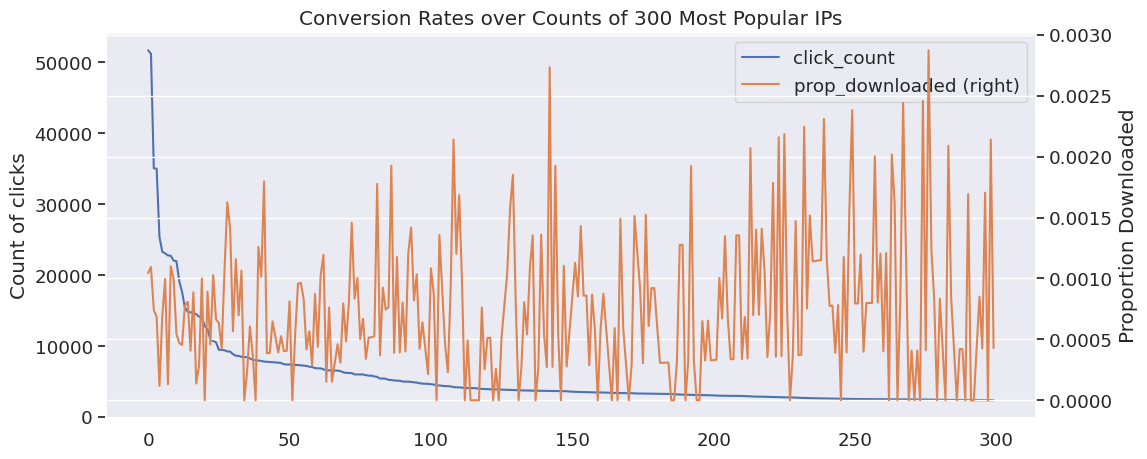

Counversion Rates over Counts of Most Popular IPs
        ip  click_count  prop_downloaded
0    73516        51711         0.001044
1    73487        51215         0.001093
2     5314        35073         0.000741
3     5348        35004         0.000686
4    53454        25381         0.000118
5   105560        23289         0.000687
6   100275        23070         0.000997
7   114276        22774         0.000132
8   201182        22719         0.001100
9   105475        22047         0.000998
10   95766        21966         0.000546
11   26995        19166         0.000470
12  209663        17605         0.000454
13   43793        15398         0.000779
14  137052        14840         0.000809
15   86767        14742         0.000407
16   17149        14673         0.000886
17  111025        14493         0.000138
18  138561        14119         0.000283
19  147957        14012         0.000999


In [82]:
proportion = train[['ip', 'is_attributed']].groupby('ip', as_index=False).mean().sort_values('is_attributed', ascending=False)
counts = train[['ip', 'is_attributed']].groupby('ip', as_index=False).count().sort_values('is_attributed', ascending=False)
merge = counts.merge(proportion, on='ip', how='left')
merge.columns = ['ip', 'click_count', 'prop_downloaded']

ax = merge[:300].plot(secondary_y = 'prop_downloaded')
plt.title('Conversion Rates over Counts of 300 Most Popular IPs')
ax.set(ylabel='Count of clicks')
plt.ylabel('Proportion Downloaded')
plt.show()

print('Counversion Rates over Counts of Most Popular IPs')
print(merge[:20])

전환율은 특정한 패턴이 없는 것은 물론이고 noise가 많으며 IP의 인기도와는 상관관계가 없어보임

### App의 download 전환율

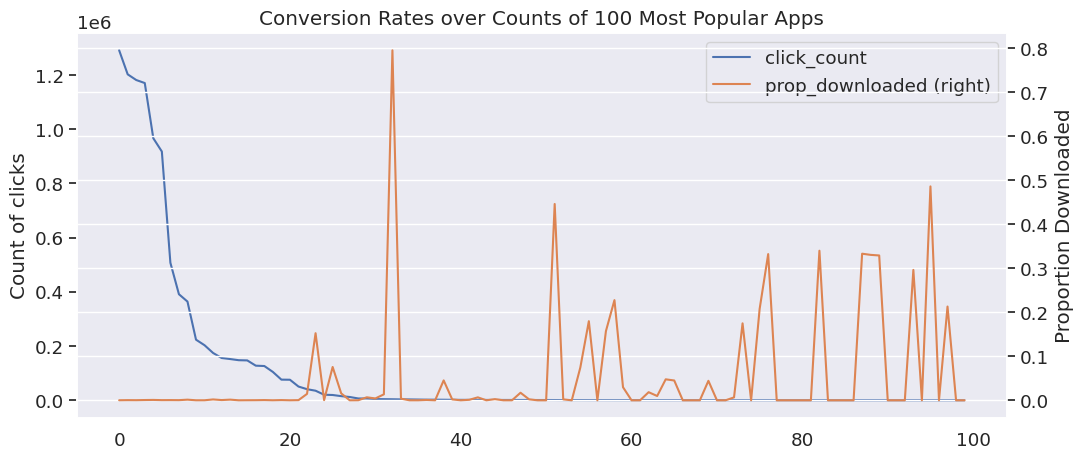

Counversion Rates over Counts of Most Popular Apps
   app  click_count  prop_downloaded
0   12      1291185         0.000140
1    2      1202534         0.000388
2   15      1181585         0.000277
3    3      1170412         0.000630
4    9       966839         0.000869
5   18       917820         0.000397
6   14       507491         0.000483
7    1       391508         0.000350
8    8       364361         0.001441
9   21       223823         0.000089
10  13       203332         0.000103
11  20       174792         0.001962
12  24       156247         0.000550
13  11       152367         0.001503
14  23       148119         0.000027
15   6       147356         0.000176
16  64       127923         0.000258
17  26       126630         0.000537
18  25       104855         0.000095
19  27        76417         0.000523


In [83]:
proportion = train[['app', 'is_attributed']].groupby('app', as_index=False).mean().sort_values('is_attributed', ascending=False)
counts = train[['app', 'is_attributed']].groupby('app', as_index=False).count().sort_values('is_attributed', ascending=False)
merge = counts.merge(proportion, on='app', how='left')
merge.columns = ['app', 'click_count', 'prop_downloaded']

ax = merge[:100].plot(secondary_y='prop_downloaded')
plt.title('Conversion Rates over Counts of 100 Most Popular Apps')
ax.set(ylabel='Count of clicks')
plt.ylabel('Proportion Downloaded')
plt.show()

print('Counversion Rates over Counts of Most Popular Apps')
print(merge[:20])

- click 수가 적을 수록 다운받은 비율의 변동이 커지고, 클릭 수가 많은 앱일수록 비율의 변화폭이 커짐.
- 다운로드를 한 비율은 대체로 0.0015 내로 유지됨

### OS 다운로드 전환율

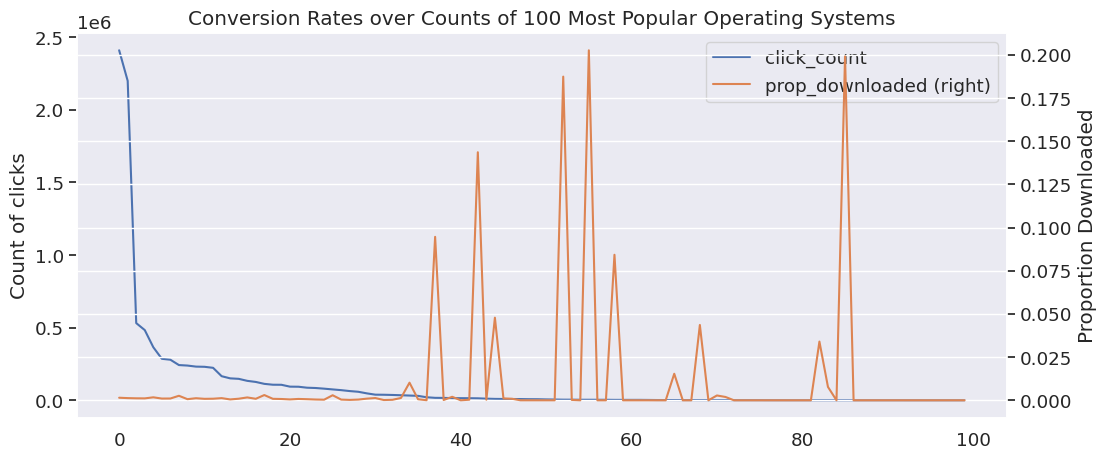

Counversion Rates over Counts of Most Popular Operating Systems
     os  click_count  prop_downloaded
0    19      2410148         0.001489
1    13      2199778         0.001271
2    17       531695         0.001155
3    18       483602         0.001115
4    22       365576         0.001729
5    10       285907         0.001011
6     8       279549         0.001037
7     6       242799         0.002619
8     9       239377         0.000656
9    25       232143         0.001206
10   15       230832         0.000853
11   20       223820         0.000920
12   16       166165         0.001258
13   37       151274         0.000509
14    3       147970         0.000919
15   14       134127         0.001663
16   41       126565         0.000877
17    1       113395         0.003042
18  607       107442         0.000856
19   12       107005         0.000757


In [84]:
proportion = train[['os', 'is_attributed']].groupby('os', as_index=False).mean().sort_values('is_attributed', ascending=False)
counts = train[['os', 'is_attributed']].groupby('os', as_index=False).count().sort_values('is_attributed', ascending=False)
merge = counts.merge(proportion, on='os', how='left')
merge.columns = ['os', 'click_count', 'prop_downloaded']

ax = merge[:100].plot(secondary_y='prop_downloaded')
plt.title('Conversion Rates over Counts of 100 Most Popular Operating Systems')
ax.set(ylabel='Count of clicks')
plt.ylabel('Proportion Downloaded')
plt.show()

print('Counversion Rates over Counts of Most Popular Operating Systems')
print(merge[:20])

비율은 0.003 이하로 매우 낮으나, app과 마찬가지로 count의 수가 낮아질수록 비율이 더 큰 폭으로 변동함

### Device 다운로드 전환율

In [85]:
proportion = train[['device', 'is_attributed']].groupby('device', as_index=False).mean().sort_values('is_attributed', ascending=False)
counts = train[['device', 'is_attributed']].groupby('device', as_index=False).count().sort_values('is_attributed', ascending=False)
merge = counts.merge(proportion, on='device', how='left')
merge.columns = ['device', 'click_count', 'prop_downloaded']

print('Count of clicks and proportion of downloads by device:')
print(merge)

Count of clicks and proportion of downloads by device:
    device  click_count  prop_downloaded
0        1      9381146         0.001326
1        2       456617         0.000208
2     3032       104393         0.000000
3        0        46476         0.091961
4       59         1618         0.001236
..     ...          ...              ...
935   1044            1         1.000000
936   1036            1         0.000000
937   1016            1         0.000000
938   1014            1         0.000000
939   3545            1         0.000000

[940 rows x 3 columns]


전환율이 가장 높은 1위 디바이스가 전체의 94%를 차지함. 해당 device의 다운로드 전환율은 0.13%

### Channel별 다운로드 전환율

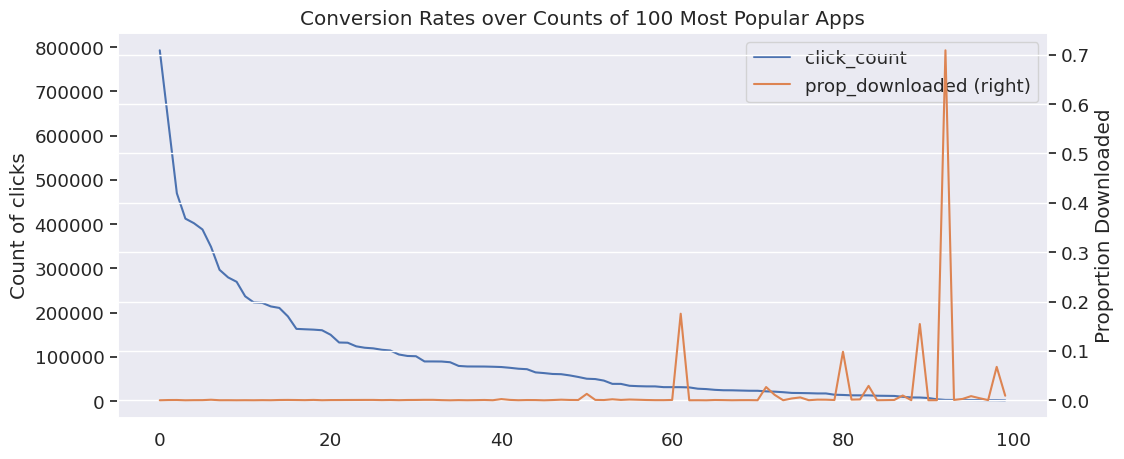

Counversion Rates over Counts of Most Popular Channels
   channel  click_count  prop_downloaded
0      245       793105         0.000105
1      134       630888         0.000558
2      259       469845         0.000653
3      477       412559         0.000073
4      121       402226         0.000323
5      107       388035         0.000379
6      145       348862         0.001155
7      153       296832         0.000182
8      205       279720         0.000232
9      178       269720         0.000119
10     265       236949         0.000236
11     128       223205         0.000130
12     140       222096         0.000347
13     459       214060         0.000187
14     442       210687         0.000646
15     215       191618         0.000778
16     122       163312         0.000582
17     280       162425         0.000345
18     379       161608         0.000811
19     135       160215         0.000200


In [86]:
proportion = train[['channel', 'is_attributed']].groupby('channel', as_index=False).mean().sort_values('is_attributed', ascending=False)
counts = train[['channel', 'is_attributed']].groupby('channel', as_index=False).count().sort_values('is_attributed', ascending=False)
merge = counts.merge(proportion, on='channel', how='left')
merge.columns = ['channel', 'click_count', 'prop_downloaded']

ax = merge[:100].plot(secondary_y='prop_downloaded')
plt.title('Conversion Rates over Counts of 100 Most Popular Apps')
ax.set(ylabel='Count of clicks')
plt.ylabel('Proportion Downloaded')
plt.show()

print('Counversion Rates over Counts of Most Popular Channels')
print(merge[:20])

전반적으로 app, os, device 전환율과 비슷함

# time pattern

시간을 한시간 단위로 반올림하여 시간별로 패턴이 존재하는지 다시 확인

시간의 흐름상으로 정리되어 있기 때문에 일부 추출한 데이터를 사용하면 안됨. 따라서 sample 데이터를 사용하기로 함.

In [87]:
train_smp = pd.read_csv('/kaggle/input/talkingdata-adtracking-fraud-detection/train_sample.csv')

In [88]:
train_smp.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,87540,12,1,13,497,2017-11-07 09:30:38,NaN,0
1,105560,25,1,17,259,2017-11-07 13:40:27,NaN,0
2,101424,12,1,19,212,2017-11-07 18:05:24,NaN,0
3,94584,13,1,13,477,2017-11-07 04:58:08,NaN,0
4,68413,12,1,1,178,2017-11-09 09:00:09,NaN,0


In [89]:
train_smp['click_time'] = pd.to_datetime(train_smp['click_time'])
train_smp['attributed_time'] = pd.to_datetime(train_smp['attributed_time'])

Text(0, 0.5, 'Converted Ratio')

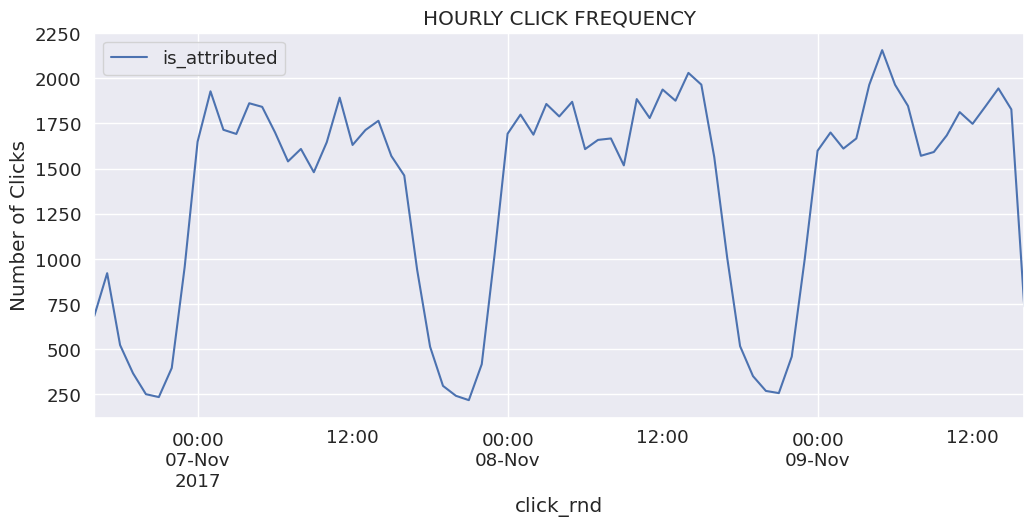

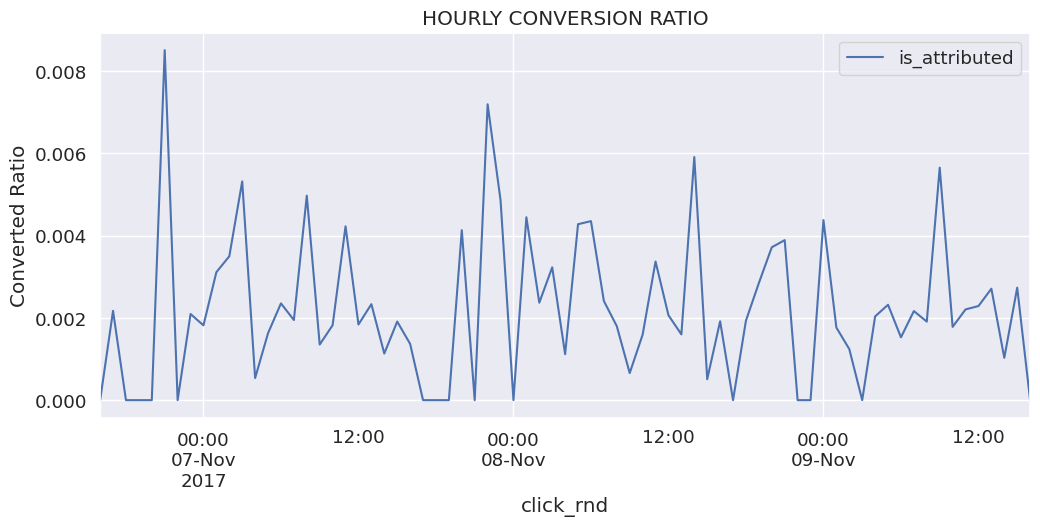

In [90]:
#round the time to nearest hour
train_smp['click_rnd']=train_smp['click_time'].dt.round('H')  

#check for hourly patterns
train_smp[['click_rnd','is_attributed']].groupby(['click_rnd'], as_index=True).count().plot()
plt.title('HOURLY CLICK FREQUENCY')
plt.ylabel('Number of Clicks')

train_smp[['click_rnd','is_attributed']].groupby(['click_rnd'], as_index=True).mean().plot()
plt.title('HOURLY CONVERSION RATIO')
plt.ylabel('Converted Ratio')

시간대에 따른 클릭 빈도엔 패턴이 존재

각 날짜의 시간대를 별도로 추출 후 결합된 추세 확인하기

In [91]:
# 시간만 추출
train_smp['click_hour'] = train_smp['click_time'].dt.hour

In [92]:
train_smp.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed,click_rnd,click_hour
0,87540,12,1,13,497,2017-11-07 09:30:38,NaT,0,2017-11-07 10:00:00,9
1,105560,25,1,17,259,2017-11-07 13:40:27,NaT,0,2017-11-07 14:00:00,13
2,101424,12,1,19,212,2017-11-07 18:05:24,NaT,0,2017-11-07 18:00:00,18
3,94584,13,1,13,477,2017-11-07 04:58:08,NaT,0,2017-11-07 05:00:00,4
4,68413,12,1,1,178,2017-11-09 09:00:09,NaT,0,2017-11-09 09:00:00,9


Text(0, 0.5, 'Number of Clicks')

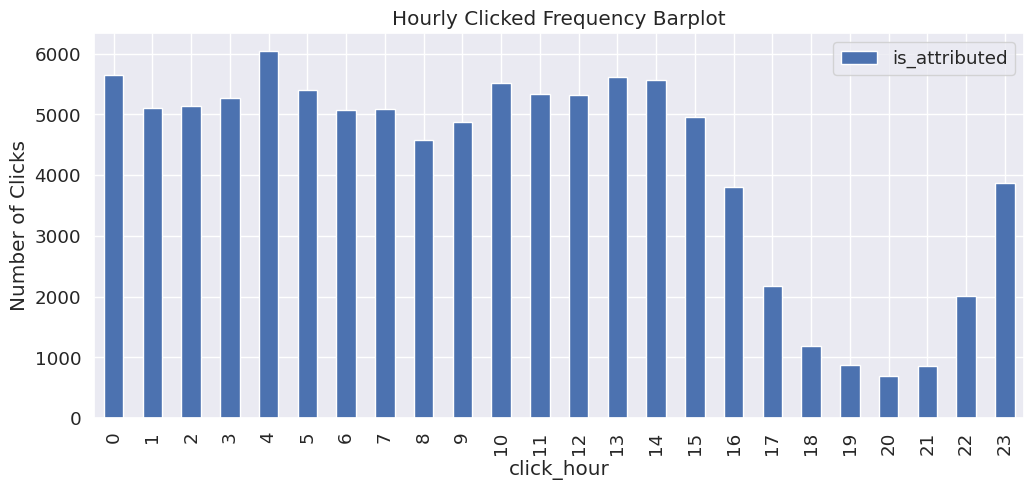

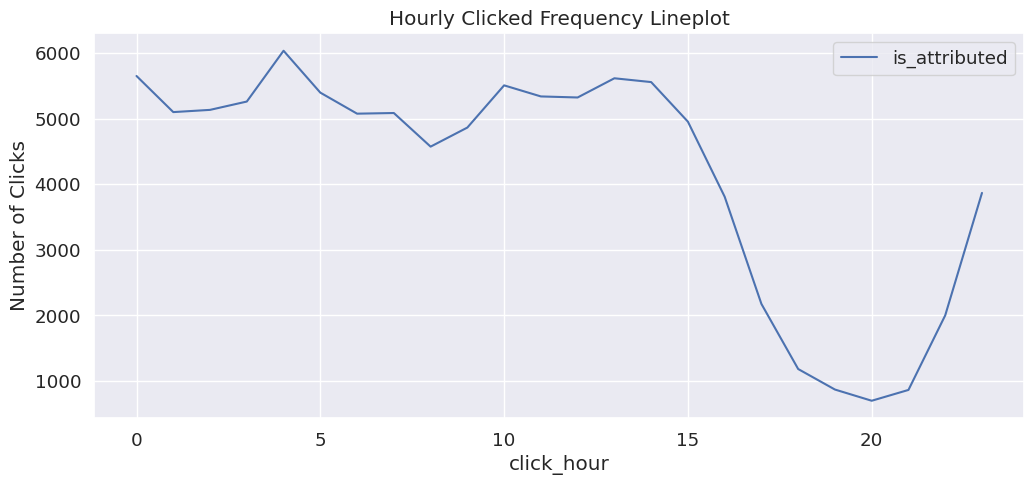

In [96]:
# 시간대별 클릭 수 확인하기
train_smp[['click_hour', 'is_attributed']].groupby(['click_hour'], as_index=True).count().plot(kind='bar')
plt.title('Hourly Clicked Frequency Barplot')
plt.ylabel('Number of Clicks')

train_smp[['click_hour', 'is_attributed']].groupby(['click_hour'], as_index=True).count().plot()
plt.title('Hourly Clicked Frequency Lineplot')
plt.ylabel('Number of Clicks')

Text(0, 0.5, 'Converted Ratio')

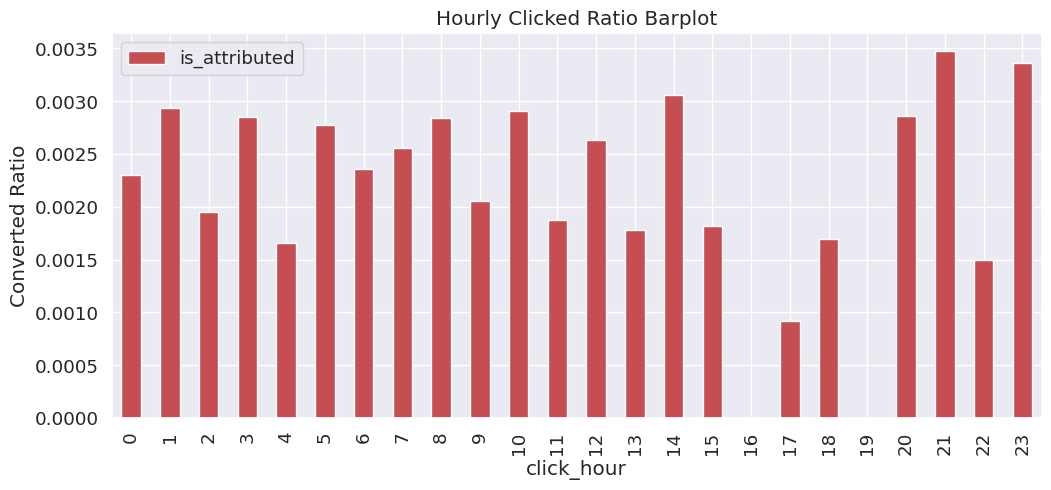

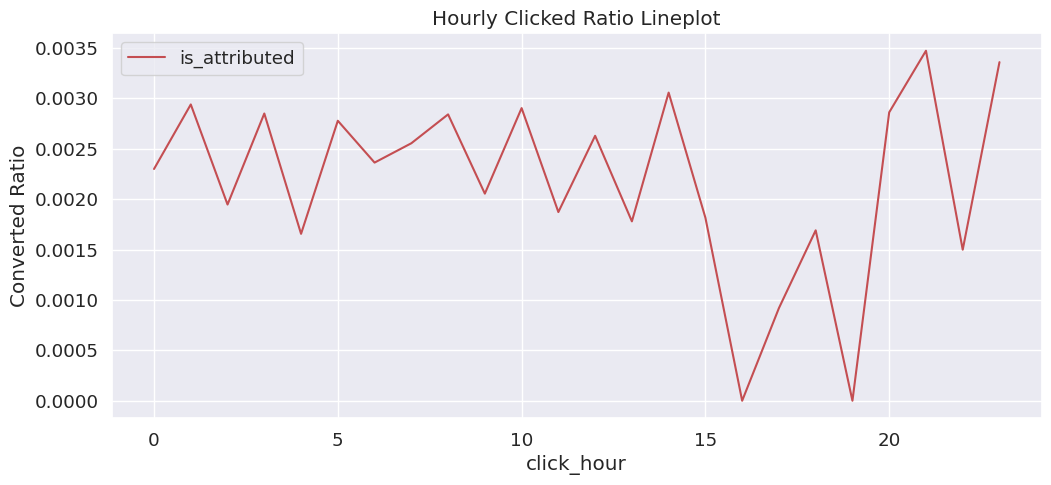

In [100]:
# 클릭 대비 다운로드 수의 비율 확인하기
train_smp[['click_hour','is_attributed']].groupby(['click_hour'], as_index=True).mean().plot(kind='bar', color='r')
plt.title('Hourly Clicked Ratio Barplot')
plt.ylabel('Converted Ratio')

train_smp[['click_hour','is_attributed']].groupby(['click_hour'], as_index=True).mean().plot( color='r')
plt.title('Hourly Clicked Ratio Lineplot')
plt.ylabel('Converted Ratio')

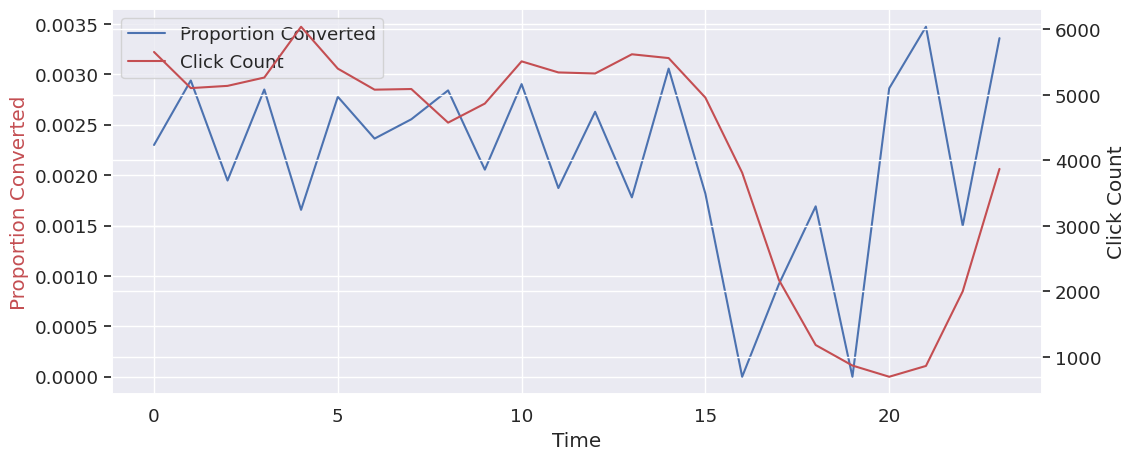

In [107]:
group = train_smp[['click_hour','is_attributed']].groupby(['click_hour'], as_index=False).mean()
x = group['click_hour']
ymean = group['is_attributed']
group = train_smp[['click_hour','is_attributed']].groupby(['click_hour'], as_index=False).count()
ycount = group['is_attributed']

fig = plt.figure()
host = fig.add_subplot(111)

par1 = host.twinx()

host.set_xlabel("Time")
host.set_ylabel("Proportion Converted")
par1.set_ylabel("Click Count")

p1, = host.plot(x, ymean, color = 'b',label = "Proportion Converted")
p2, = par1.plot(x, ycount, color = 'r', label = "Click Count")

lns = [p1, p2]
host.legend(handles = lns, loc = 'best')

host.yaxis.label.set_color(p1.get_color())
host.yaxis.label.set_color(p2.get_color())

plt.savefig("pyplot_multiple_y-axis.png", bbox_inches='tight')

Text(0, 0.5, 'Converted Ratio')

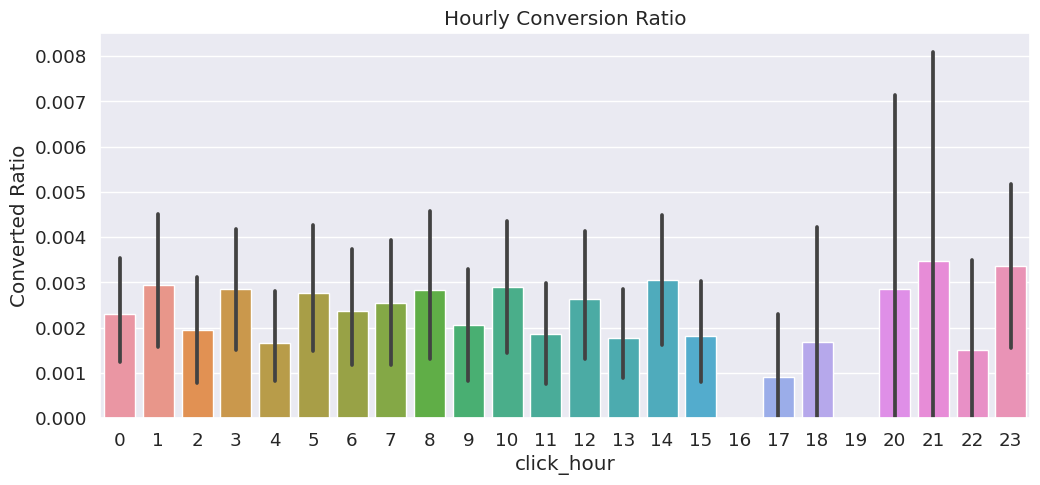

In [110]:
sns.barplot(x = 'click_hour', y = 'is_attributed', data=train_smp)
plt.title('Hourly Conversion Ratio')
plt.ylabel('Converted Ratio')

sample data는 클릭 수의 파이가 심하기 때문에 특히 클릭 수가 적은 시간대의 경우 비율의 변동성이 너무 커서 판단하기 힘듦. <br>
클릭 / 다운로드 전환율이 적을수록 추정 전환율의 마진이 더 넓어짐

### 다운로드 시간 확인하기

광고를 클릭한 후 다운로드까지 얼마나 많은 시간이 걸렸는지 살펴보기

In [111]:
train_smp['time_pass'] = train_smp['attributed_time'] - train_smp['click_time']
train_smp[train_smp['is_attributed']==1][:15]

,ip,app,device,os,channel,click_time,attributed_time,is_attributed,click_rnd,click_hour,time_pass
284,224120,19,0,29,213,2017-11-08 02:22:13,2017-11-08 02:22:38,1,2017-11-08 02:00:00,2,0 days 00:00:25
481,272894,10,1,7,113,2017-11-08 06:10:05,2017-11-08 06:10:37,1,2017-11-08 06:00:00,6,0 days 00:00:32
1208,79001,19,0,0,213,2017-11-07 09:54:22,2017-11-07 11:59:05,1,2017-11-07 10:00:00,9,0 days 02:04:43
1341,131029,19,0,0,343,2017-11-09 10:58:46,2017-11-09 11:52:01,1,2017-11-09 11:00:00,10,0 days 00:53:15
1412,40352,19,0,0,213,2017-11-07 22:19:03,2017-11-08 01:55:02,1,2017-11-07 22:00:00,22,0 days 03:35:59
1666,48733,35,1,18,274,2017-11-07 12:25:50,2017-11-07 13:10:30,1,2017-11-07 12:00:00,12,0 days 00:44:40
1771,330861,35,1,22,21,2017-11-08 18:54:44,2017-11-08 22:39:52,1,2017-11-08 19:00:00,18,0 days 03:45:08
1917,309576,5,1,32,113,2017-11-09 08:47:51,2017-11-09 08:47:55,1,2017-11-09 09:00:00,8,0 days 00:00:04
3914,220571,71,1,25,3,2017-11-08 04:35:21,2017-11-08 04:37:46,1,2017-11-08 05:00:00,4,0 days 00:02:25
3992,240051,35,1,19,21,2017-11-08 08:07:13,2017-11-08 09:46:42,1,2017-11-08 08:00:00,8,0 days 01:39:29


In [113]:
train_smp['time_pass'].describe()

count                          227
mean     0 days 01:14:59.572687224
std      0 days 02:25:05.392661298
min                0 days 00:00:02
25%         0 days 00:00:52.500000
50%                0 days 00:03:18
75%         0 days 01:21:27.500000
max                0 days 12:52:21
Name: time_pass, dtype: object

클릭에서 구매까지 짤베근 2초, 길게는 13시간까지 걸림.

2초 안에 다운로드 결정을 내리는 것엔 무리가 있기에, 이전에 광고를 본 사람이라고 추측됨

### 실제 데이터 처음 10,000,000행으로 확인해보기

In [114]:
#check first 10,000,000 of actual train data
train['time_pass']= train['attributed_time']-train['click_time']
train['time_pass'].describe()

count                        18717
mean     0 days 03:48:02.893732970
std      0 days 05:29:41.396810741
min                0 days 00:00:00
25%                0 days 00:01:26
50%                0 days 00:25:03
75%                0 days 06:34:14
max                0 days 23:52:38
Name: time_pass, dtype: object

같은 ip의 클릭 횟수가 많고, 다운로드까지 걸린 시간이 비교적 짧은 것으로 보아, 단 한 번의 틀릭만으로 다운로드가 되었다고는 볼 수 없음. <br>
다운로드를 할 의도로 광고를 보았을 경우도 있음.

refer : kaggle [TalkingData EDA plus time patterns](https://www.kaggle.com/code/yuliagm/talkingdata-eda-plus-time-patterns)